In [11]:
#Data Preprocessing
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("KNNClassifier").getOrCreate()

# Load the training data from train.csv
train_data = spark.read.csv("C:/Users/withm/OneDrive/Desktop/DTSC 701/lab4/train.csv", header=True, inferSchema=True)

# Load and preprocess the testing data from "test.csv"
test_data = spark.read.csv("C:/Users/withm/OneDrive/Desktop/DTSC 701/lab4/test.csv", header=True, inferSchema=True)

In [12]:
#Check uploaded data format
train_data.head(5)

[Row(PassengerId=1, Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S'),
 Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38.0, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C'),
 Row(PassengerId=3, Survived=1, Pclass=3, Name='Heikkinen, Miss. Laina', Sex='female', Age=26.0, SibSp=0, Parch=0, Ticket='STON/O2. 3101282', Fare=7.925, Cabin=None, Embarked='S'),
 Row(PassengerId=4, Survived=1, Pclass=1, Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex='female', Age=35.0, SibSp=1, Parch=0, Ticket='113803', Fare=53.1, Cabin='C123', Embarked='S'),
 Row(PassengerId=5, Survived=0, Pclass=3, Name='Allen, Mr. William Henry', Sex='male', Age=35.0, SibSp=0, Parch=0, Ticket='373450', Fare=8.05, Cabin=None, Embarked='S')]

In [13]:
#Handle Null Value
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import avg

# Handle null values in "Age" by dropping rows with null values
data_no_null_age = train_data.filter(train_data.Age.isNotNull())

# Handle null values in "SibSp" and "Parch" by imputing with the mean value
imputer_sibsp_parch = Imputer(inputCols=["SibSp", "Parch"], outputCols=["imputed_SibSp", "imputed_Parch"])
imputer_model = imputer_sibsp_parch.fit(data_no_null_age)
data_imputed_sibsp_parch = imputer_model.transform(data_no_null_age)

# Handle null values in "Fare" by imputing with the mean value
fare_mean = data_imputed_sibsp_parch.agg(avg("Fare")).first()[0]
data_imputed_fare = data_imputed_sibsp_parch.fillna(fare_mean, subset=["Fare"])

In [14]:
#Write standard scaler from scratch & Scale the data using standard scaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Define a User-Define-Function(UDF) to subtract the mean and divide by the standard deviation
def scale_features(age, sibsp, parch, fare):
    scaled_age = (age - age_mean) / (age_stddev if age_stddev != 0 else 1)
    scaled_sibsp = (sibsp - sibsp_mean) / (sibsp_stddev if sibsp_stddev != 0 else 1)
    scaled_parch = (parch - parch_mean) / (parch_stddev if parch_stddev != 0 else 1)
    scaled_fare = (fare - fare_mean) / (fare_stddev if fare_stddev != 0 else 1)
    return Vectors.dense(scaled_age, scaled_sibsp, scaled_parch, scaled_fare)

# Register the UDF
scaled_features_udf = udf(scale_features, DoubleType())

# Apply the UDF to create a new column "scaled_features"
scaled_data = data_imputed_fare.withColumn("scaled_features", scaled_features_udf(data_imputed_fare["Age"], data_imputed_fare["imputed_SibSp"], data_imputed_fare["imputed_Parch"], data_imputed_fare["Fare"]))

# Display the first 10 rows of the scaled data
scaled_data.select("PassengerId", "Survived").show(10, truncate=False)

+-----------+--------+
|PassengerId|Survived|
+-----------+--------+
|1          |0       |
|2          |1       |
|3          |1       |
|4          |1       |
|5          |0       |
|7          |0       |
|8          |0       |
|9          |1       |
|10         |1       |
|11         |1       |
+-----------+--------+
only showing top 10 rows



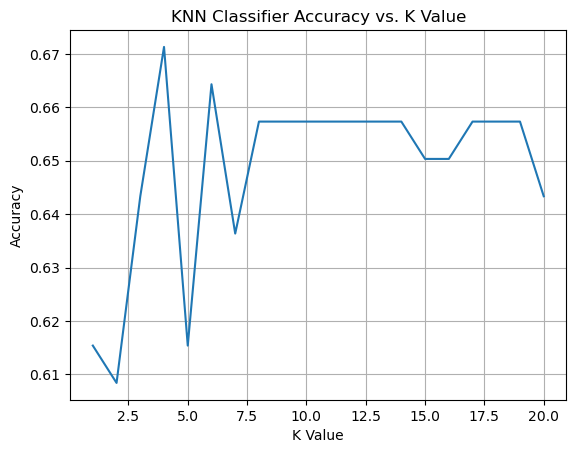

The best K value is: 4


In [17]:
#Determine the K value, and create a visualization of the accuracy. Report the best K value.

import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

train_data = train_data.dropna(subset=["Age", "SibSp", "Parch", "Fare"])

# Feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = train_data[["Age", "SibSp", "Parch", "Fare"]]
X = scaler.fit_transform(X)

y = train_data["Survived"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of K values to try
k_values = list(range(1, 21))

accuracy_scores = []

for k in k_values:
    # Create a KNN classifier with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)

    # Train the model
    knn.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = knn.predict(X_test)

    # Evaluate the model using accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores for different K values
plt.plot(k_values, accuracy_scores)
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.title("KNN Classifier Accuracy vs. K Value")
plt.grid(True)
plt.show()

# Find the best K value
best_k = k_values[accuracy_scores.index(max(accuracy_scores))]
print("The best K value is:", best_k)

In [16]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix

# Define the KNN classifier with the best K value
best_k = 4
knn = KNeighborsClassifier(n_neighbors=best_k)

# Perform 5-fold cross-validation and report mean and standard deviation of accuracy
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

# Train the model on the entire training dataset
knn.fit(X, y)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(confusion)

Mean Accuracy: 0.7016645326504481
Standard Deviation of Accuracy: 0.03066486046078227
Confusion Matrix:
[[79  8]
 [33 23]]


According to 5-fold cross-validation, the mean accuracy is 70.17% and the standard deviation of accuracy is 3.07% only.